# Comparing different Classification Machine Learning Models

Getting a loan approved depends on alot of factors and at times individuals who get their loan approved might not pay it off completely leading to default in payment.  
The goal of this project is to use classification models to predict if individuals will default their payment or pay it off.

The four classification models are listed below:
1. K Nearest Neighbor (KNN)
2. Decision Tree
3. Support Vector Machine 
4. Logistic Regression 

The model accuracy is assessed using:
1. Jaccard Score 
2. F1-Score 
3. Log loss

Let the best model WIN!


In [284]:
#Importing packages
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [285]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-07-23 07:41:18--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2020-07-23 07:41:18 (12.4 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [286]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [287]:
df.shape

(346, 10)

### Convert to date time object 

In [288]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing

Let’s see how many of each class is in our data set 

In [289]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

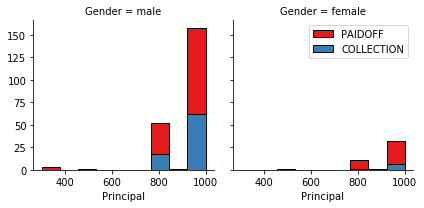

In [290]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

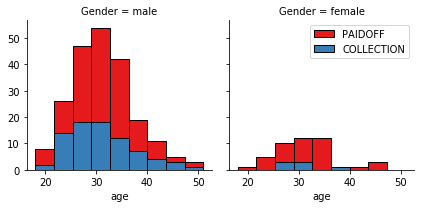

In [291]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

 Lets look at the day of the week people get the loan 

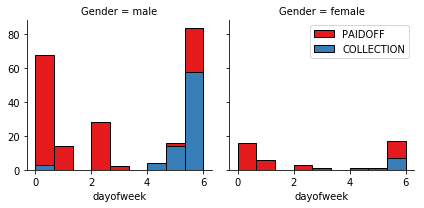

In [292]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [293]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [294]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [295]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
 How about education?

In [296]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

Features before One Hot Encoding

In [297]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


Use one hot encoding technique to convert categorical varables to binary variables and append them to the feature Data Frame 

In [298]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets define feature sets, X:

In [299]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [300]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [301]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.52,  0.92,  2.33, -0.42, -1.21, -0.38,  1.14, -0.87],
       [ 0.52,  0.92,  0.34,  2.38, -1.21,  2.62, -0.88, -0.87],
       [ 0.52, -0.96, -0.65, -0.42, -1.21, -0.38, -0.88,  1.15],
       [ 0.52,  0.92, -0.49,  2.38,  0.83, -0.38, -0.88,  1.15],
       [ 0.52,  0.92, -0.32, -0.42,  0.83, -0.38, -0.88,  1.15]])

# Classification 

Now, let's use the training set to build an accurate model. After that, use the test set to report the accuracy of the model.
The following algorithms are used:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression


# K Nearest Neighbor(KNN)

In [302]:
# Importing packages
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

#Assigning training and testing data
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)



Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [303]:
# Checking the different k's ranging from 1-10 to see which gives the highest mean accuracy
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks): # (1,k's) = (1:10)
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.67, 0.66, 0.71, 0.69, 0.76, 0.71, 0.79, 0.76, 0.76])

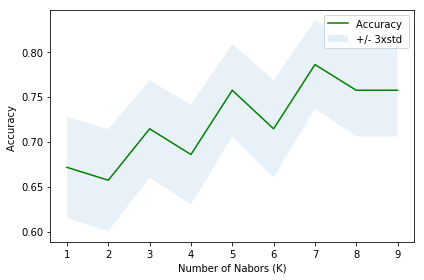

The best accuracy was with 0.7857142857142857 with k= 7


In [304]:
#Plotting model accuracy for the different K's
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

In [305]:
#Buidling a KNN model when K=7
k = 7
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=7, p=2,
           weights='uniform')

In [306]:
# Using the model to predict X_test
yhat = neigh.predict(X_test)
yhat[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [307]:
#Comparing accuracy for the Training Set & Testing Set
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.8079710144927537
Test set Accuracy:  0.7857142857142857


# Decision Tree

In [308]:
from sklearn.tree import DecisionTreeClassifier

# Checking the different mxd ranging from 1-10 to see which gives the highest mean accuracy
mxd = 10
mean_acc = np.zeros((mxd-1))
std_acc = np.zeros((mxd-1))
ConfustionMx = [];
for n in range(1,mxd): 
    
    #Train Model and Predict  
    drugTree = DecisionTreeClassifier(criterion="entropy", max_depth = n).fit(X_train,y_train)
    predTree = drugTree.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, predTree)

    
    std_acc[n-1]=np.std(predTree==y_test)/np.sqrt(predTree.shape[0])

mean_acc

array([0.79, 0.79, 0.61, 0.61, 0.64, 0.77, 0.76, 0.76, 0.66])

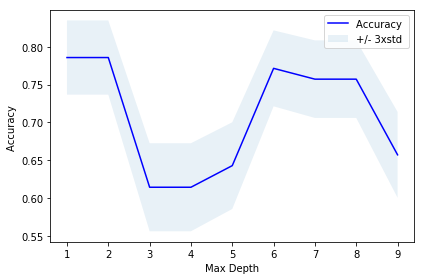

In [309]:
#Plotting model accuracy for the different K's
plt.plot(range(1,mxd),mean_acc,'b')
plt.fill_between(range(1,mxd),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Max Depth')
plt.tight_layout()
plt.show()


In [310]:
from sklearn.tree import DecisionTreeClassifier

# Modeling the Decision Tree with max_depth=2
drugTree = DecisionTreeClassifier(criterion="entropy", max_depth = 2)
drugTree # it shows the default parameters

#Training the data
drugTree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [311]:
#Prediction 
predTree = drugTree.predict(X_test)

#Comparing the predicted classes to the actual classes
print (predTree [0:5])
print (y_test [0:5])

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


In [312]:
from sklearn import metrics
print("DecisionTrees's Accuracy: %.4f" % metrics.accuracy_score(y_test, predTree))
print("F1 score: %.4f" % f1_score(y_test, predTree, average='weighted'))

DecisionTrees's Accuracy: 0.7857
F1 score: 0.6914


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [313]:
# Modeling the Decision Tree with max_depth = 6 
drugTree = DecisionTreeClassifier(criterion="entropy", max_depth = 6)
drugTree # it shows the default parameters

#Training the data
drugTree.fit(X_train,y_train)

#Prediction 
predTree = drugTree.predict(X_test)

print("DecisionTrees's Accuracy: %.4f" % metrics.accuracy_score(y_test, predTree))
print("F1 score: %.4f" % f1_score(y_test, predTree, average='weighted'))

DecisionTrees's Accuracy: 0.7714
F1 score: 0.7065


The F1 score when the **max_depths = 6** is better than when the max_depths = 2. Therefore the decision tree is modeled with max_depth = 6.

# Support Vector Machine

In [314]:
from sklearn import svm

# Testing all the kernels 

#Kernel = 'rbf'
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 
clf_pred = clf.predict(X_test)

#Kernel = 'linear'
clfl = svm.SVC(kernel='linear')
clfl.fit(X_train, y_train) 
clfl_pred = clfl.predict(X_test)

#Kernel = 'poly'
clfp = svm.SVC(kernel='poly')
clfp.fit(X_train, y_train) 
clfp_pred = clfp.predict(X_test)

#Kernel = 'sigmoid'
clfs = svm.SVC(kernel='sigmoid')
clfs.fit(X_train, y_train) 
clfs_pred = clfs.predict(X_test)

# Accuracy Scores for each of kernels
print("Test set Accuracy when kernel is rbf: ", metrics.accuracy_score(y_test, clf_pred))
print("Testing set accuracy when kernel is linear: ", metrics.accuracy_score(y_test, clfl_pred))
print("Testing set accuracy when kernel is linear: ", metrics.accuracy_score(y_test, clfp_pred))
print("Test set Accuracy when kernel is rbf: ", metrics.accuracy_score(y_test, clfs_pred))

Test set Accuracy when kernel is rbf:  0.7428571428571429
Testing set accuracy when kernel is linear:  0.7857142857142857
Testing set accuracy when kernel is linear:  0.7714285714285715
Test set Accuracy when kernel is rbf:  0.7428571428571429


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


### Evaluating the models using Confusion Matrix

In [315]:
from sklearn.metrics import classification_report, confusion_matrix

In [316]:
#defining function for confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

  COLLECTION       0.36      0.27      0.31        15
     PAIDOFF       0.81      0.87      0.84        55

   micro avg       0.74      0.74      0.74        70
   macro avg       0.59      0.57      0.57        70
weighted avg       0.72      0.74      0.73        70

Confusion matrix, without normalization
[[48  7]
 [11  4]]


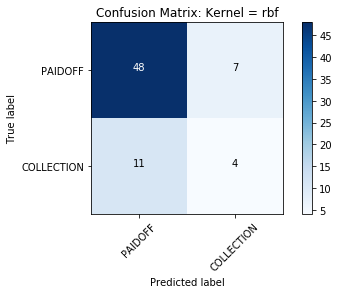

In [317]:
# Compute confusion matrix kernel = rbf
label = ['PAIDOFF','COLLECTION']
cnf_matrix = confusion_matrix(y_test, clf_pred, labels=label)
np.set_printoptions(precision=2)

print (classification_report(y_test, clf_pred))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion Matrix: Kernel = rbf')

              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        15
     PAIDOFF       0.79      1.00      0.88        55

   micro avg       0.79      0.79      0.79        70
   macro avg       0.39      0.50      0.44        70
weighted avg       0.62      0.79      0.69        70

Confusion matrix, without normalization
[[55  0]
 [15  0]]


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


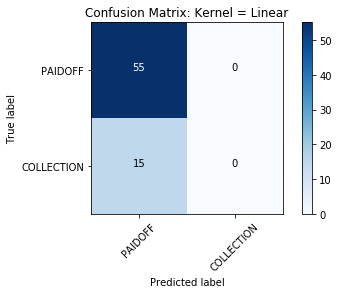

In [318]:
# Compute confusion matrix kernel = Linear
label = ['PAIDOFF','COLLECTION']
cnfl_matrix = confusion_matrix(y_test, clfl_pred, labels=label)
np.set_printoptions(precision=2)

print (classification_report(y_test, clfl_pred))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnfl_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion Matrix: Kernel = Linear')

              precision    recall  f1-score   support

  COLLECTION       0.33      0.07      0.11        15
     PAIDOFF       0.79      0.96      0.87        55

   micro avg       0.77      0.77      0.77        70
   macro avg       0.56      0.52      0.49        70
weighted avg       0.69      0.77      0.71        70

Confusion matrix, without normalization
[[53  2]
 [14  1]]


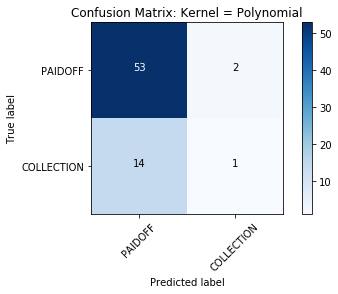

In [319]:
# Compute confusion matrix kernel = Polynomial
label = ['PAIDOFF','COLLECTION']
cnfp_matrix = confusion_matrix(y_test, clfp_pred, labels=label)
np.set_printoptions(precision=2)

print (classification_report(y_test, clfp_pred))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnfp_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion Matrix: Kernel = Polynomial')

              precision    recall  f1-score   support

  COLLECTION       0.20      0.07      0.10        15
     PAIDOFF       0.78      0.93      0.85        55

   micro avg       0.74      0.74      0.74        70
   macro avg       0.49      0.50      0.48        70
weighted avg       0.66      0.74      0.69        70

Confusion matrix, without normalization
[[51  4]
 [14  1]]


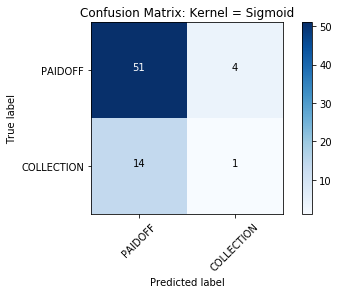

In [320]:
# Compute confusion matrix kernel = Sigmoid
label = ['PAIDOFF','COLLECTION']
cnfs_matrix = confusion_matrix(y_test, clfs_pred, labels=label)
np.set_printoptions(precision=2)

print (classification_report(y_test, clfs_pred))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnfs_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion Matrix: Kernel = Sigmoid')

In [321]:
# Accuracy & F1 score
print("F1 score: %.4f" % f1_score(y_test, clf_pred, average='weighted'))
print("Test set Accuracy: %.4f" % metrics.accuracy_score(y_test, clf_pred))

F1 score: 0.7276
Test set Accuracy: 0.7429


The predicted values of the SVM with a linear and polynomial kernel predicted all the values as "PAIDOFF" and ignored "COLLECTION" making them . The SVM with the rbf and sigmoid kernel have the same accuracy **0.7429** and the models predicted the "COLLECTION" values as well. In conclusion, the rbf kernel is the best fit among the two because of a better F1 score.


# Logistic Regression

In [322]:
from sklearn.linear_model import LogisticRegression

Evaluating the best **solver** parameter to use in the model

              precision    recall  f1-score   support

  COLLECTION       0.18      0.13      0.15        15
     PAIDOFF       0.78      0.84      0.81        55

   micro avg       0.69      0.69      0.69        70
   macro avg       0.48      0.48      0.48        70
weighted avg       0.65      0.69      0.67        70

Confusion matrix, without normalization
[[46  9]
 [13  2]]


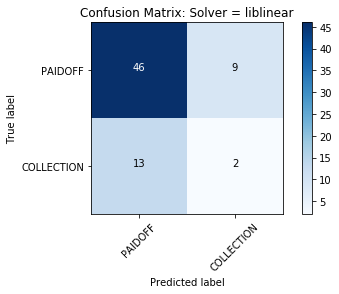

In [323]:
# Training the data with solver = 'liblinear'
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR1 = LR.predict(X_test)

# Compute confusion matrix 
label = ['PAIDOFF','COLLECTION']
LR1_matrix = confusion_matrix(y_test, LR1, labels=label)
np.set_printoptions(precision=2)

print (classification_report(y_test, LR1))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(LR1_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion Matrix: Solver = liblinear')


              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        15
     PAIDOFF       0.79      1.00      0.88        55

   micro avg       0.79      0.79      0.79        70
   macro avg       0.39      0.50      0.44        70
weighted avg       0.62      0.79      0.69        70

Confusion matrix, without normalization
[[55  0]
 [15  0]]


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


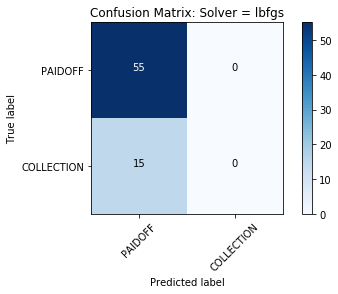

In [324]:
# Training the data with solver = 'lbfgs'
LR_lbfgs = LogisticRegression(C=0.01, solver='lbfgs').fit(X_train,y_train)
LR2 = LR_lbfgs.predict(X_test)

# Compute confusion matrix 
label = ['PAIDOFF','COLLECTION']
LR2_matrix = confusion_matrix(y_test, LR2, labels=label)
np.set_printoptions(precision=2)

print (classification_report(y_test, LR2))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(LR2_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion Matrix: Solver = lbfgs')



              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        15
     PAIDOFF       0.79      1.00      0.88        55

   micro avg       0.79      0.79      0.79        70
   macro avg       0.39      0.50      0.44        70
weighted avg       0.62      0.79      0.69        70

Confusion matrix, without normalization
[[55  0]
 [15  0]]


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


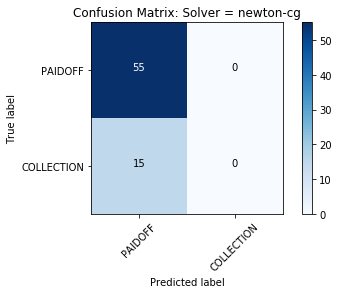

In [325]:
# Training the data with solver = 'newton-cg'
LR_newtoncg = LogisticRegression(C=0.01, solver='newton-cg').fit(X_train,y_train)
LR3 = LR_newtoncg.predict(X_test)

# Compute confusion matrix 
label = ['PAIDOFF','COLLECTION']
LR3_matrix = confusion_matrix(y_test, LR3, labels=label)
np.set_printoptions(precision=2)

print (classification_report(y_test, LR3))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(LR3_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion Matrix: Solver = newton-cg')

              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        15
     PAIDOFF       0.79      1.00      0.88        55

   micro avg       0.79      0.79      0.79        70
   macro avg       0.39      0.50      0.44        70
weighted avg       0.62      0.79      0.69        70

Confusion matrix, without normalization
[[55  0]
 [15  0]]


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


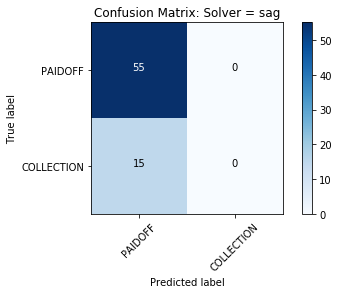

In [326]:
# Training the data with solver = 'sag'
LR_sag = LogisticRegression(C=0.01, solver='sag').fit(X_train,y_train)
LR4 = LR_sag.predict(X_test)

# Compute confusion matrix 
label = ['PAIDOFF','COLLECTION']
LR4_matrix = confusion_matrix(y_test, LR4, labels=label)
np.set_printoptions(precision=2)

print (classification_report(y_test, LR4))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(LR4_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion Matrix: Solver = sag')

              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        15
     PAIDOFF       0.79      1.00      0.88        55

   micro avg       0.79      0.79      0.79        70
   macro avg       0.39      0.50      0.44        70
weighted avg       0.62      0.79      0.69        70

Confusion matrix, without normalization
[[55  0]
 [15  0]]


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


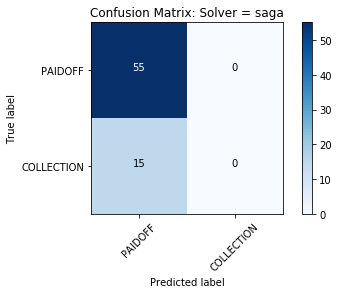

In [327]:
# Training the data with solver = 'saga'
LR_saga = LogisticRegression(C=0.01, solver='saga').fit(X_train,y_train)
LR5 = LR_saga.predict(X_test)

# Compute confusion matrix 
label = ['PAIDOFF','COLLECTION']
LR5_matrix = confusion_matrix(y_test, LR5, labels=label)
np.set_printoptions(precision=2)

print (classification_report(y_test, LR5))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(LR5_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion Matrix: Solver = saga')

In [329]:
# Checking the accuracy score and F1 score
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR1 = LR.predict(X_test)

print("Test set Accuracy: %.4f" % metrics.accuracy_score(y_test, LR1))
print("F1 score: %.4f" % f1_score(y_test, LR1, average='weighted'))


Test set Accuracy: 0.6857
F1 score: 0.6671


Except for the liblinear solver all other model has did not include "COLLECTION" in the prediction. Therefore, the best logistic model for prediction will be where the solver paramenter is equal to **liblinear** 

# Model Evaluation using Test set

In [330]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-07-23 07:47:55--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-07-23 07:47:55 (182 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [331]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [332]:
# shape of the test data set 
test_df.shape

(54, 10)

In [333]:
# Count of the loan status 
test_df['loan_status'].value_counts()

PAIDOFF       40
COLLECTION    14
Name: loan_status, dtype: int64

# Pre-processing

In [334]:
df = test_df

# Using Feature binarization to set a threshold values less then day 4 and assigning the values to a new column 'Weekend'
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df['dayofweek'] = df['effective_date'].dt.dayofweek
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

# Convert Categorical features to numerical values 
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

df.groupby(['education'])['loan_status'].value_counts(normalize=True)

# One hot-encoding
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)

# Feature selection
X_test = Feature
y_test = df['loan_status'].values

# Normalize Data
X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:25: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.


# Model Evaluation

### KNN

In [335]:
# Prediction 
knn_test = neigh.predict(X_test)

# F1 score
f1_knn = f1_score(y_test, knn_test, average='weighted')

# Jaccard scoreel
jsc_knn = jaccard_similarity_score(y_test, knn_test)

# Printing the scores
print("F1 score: ", f1_knn)
print("Jaccard score: ", jsc_knn)

F1 score:  0.6328400281888654
Jaccard score:  0.6666666666666666


### Decision Tree

In [336]:
# Prediction 
dec_test = drugTree.predict(X_test)

# F1 score
f1_dec = f1_score(y_test, dec_test, average='weighted')

# Jaccard score
jsc_dec = jaccard_similarity_score(y_test, dec_test)

# Printing the scores
print("F1 score: ", f1_dec)
print("Jaccard score: ", jsc_dec)

F1 score:  0.6704776923582364
Jaccard score:  0.7222222222222222


### Support Vector Machines

In [337]:
# Prediction 
svm_test = clf.predict(X_test)

# F1 score
f1_svm = f1_score(y_test, svm_test, average='weighted')

# Jaccard score
jsc_svm = jaccard_similarity_score(y_test, svm_test)

# Printing the scores
print("F1 score: ", f1_svm)
print("Jaccard score: ", jsc_svm)


F1 score:  0.7583503077293734
Jaccard score:  0.7962962962962963


### Logistic Regression

In [338]:
# Prediction 
LR_test = LR.predict(X_test)

# F1 score
f1_LR = f1_score(y_test, LR_test, average='weighted')

# Jaccard score
jsc_LR =  jaccard_similarity_score(y_test, LR_test)

# Log loss
lr_prob = LR.predict_proba(X_test)
ll_LR =  log_loss(y_test, lr_prob)

# Printing the scores
print("F1 Score: ", f1_LR)
print("Jaccard Score: ", jsc_LR)
print("Log Loss: ", ll_LR)



F1 Score:  0.6604267310789049
Jaccard Score:  0.7407407407407407
Log Loss:  0.5672153379912981


# Comparing all the Models

In [339]:
jaccard = [0.6666666666666666,0.7222222222222222,0.7962962962962963,0.7407407407407407]
formatted_jaccard = [ '%.4f' % elem for elem in jaccard ] #reducing the number of decimels

f1_score = [0.6328400281888654,0.6704776923582364,0.7583503077293734,0.6604267310789049]
formatted_f1 = ['%.4f' % elem for elem in f1_score ]

logloss = ['NA','NA','NA','%.4f'% 0.5672153379912981]

# Creating a dictionary called df    
df = {'Algorithm': ['KNN', 'Decistion Tree', 'SVM', 'LogisticRegression'], \
     'Jaccard': formatted_jaccard, 'F1-score': formatted_f1, 'LogLoss': logloss}

# Coverting the dictionary 'df' to a dataframe 'Final_Report'
Final_Report = pd.DataFrame(data=df, columns=['Algorithm', 'Jaccard', 'F1-score', 'LogLoss'], index=None)
Final_Report

,Algorithm,Jaccard,F1-score,LogLoss
0,KNN,0.6667,0.6328,NA
1,Decistion Tree,0.7222,0.6705,NA
2,SVM,0.7963,0.7584,NA
3,LogisticRegression,0.7407,0.6604,0.5672


# Conclusion

Support Machine Vector Model WINS! Compared to the other models, SVM had the best Jaccard and F1-Score. The table above shows the models and their respective scores in a tabular form. 